# Chapter06 학습 관련 기술들

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

### 6.1 매개변수 갱신

- 확률적 경사 하강법 (SGD) :

 $W ← W - \eta \frac{\partial L}{\partial W}$

 - $W$ : 갱신할 매개변수

 - $\eta$ : 학습률

 - $\frac{\partial L}{\partial W}$ : W에 대한 손실함수의 기울기

 기울어진 방향으로 일정 거리만 가겠다는 단순한 방법

In [2]:
# SGD 구현
class SGD(object):
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):   # 갱신
        for key in params.keys():
            params[key] -= self.lr * grads[key]

    # SGD 과정에서 반복해서 update()메서드를 부른다

SGD 클래스를 사용하면 신경망의 매개변수 진행을 다음과 같이 수행할 수 있다.

    network = TwoLayerNet(...)
    optimizer = SGD()

    for i in range(10000):
        ...
        x_batch, t_batch = get_mini_batch(...)
        grads = network.gradient(x_batch, t_batch)
        params = network.params
        optimizer.update(params, grads)
        ...
    
이렇게 optimizer에 매개변수와 기울기만 전달해주면 된다.

---

SGD의 단점 : 비등방성 함수에서 탐색 경로가 비효율적이다. ( 지그재그로 탐색 )

- **모멘텀** : 

 $v ← \alpha v - \eta \frac{\partial L}{\partial W}$

 $W ← W + v$

즉, Gradient의 진행이 [그림 6-3] 에서와 같았다면 위 아래로 변하는 b축 gradient factor들은 더하기 빼기 해주게 되면서 서서히 속도가 0으로 가까워 질 것이고, 오른쪽으로 계속 진행되는 gradient의 W축 방향 factor들은 계속 더해주게 되어 관성이 작용하는 것 처럼 속도가 점점 붙을 것이다.

In [3]:
# 모멘텀 구현

class Momentum(object):
    def __init__(self, lr=0.01, momentum=0.9):  # 대체로 momentum=0.9로 설정
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):    
        if self.v is None:      # v: 0으로 초기화 
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]
        
# v는 이전 갱신에 영향을 받게 되며, 이전 갱신값이 크다면, 이번에 그만큼 가속도를 받게 된다

학습률 감소 : 학습을 진행하면서 학습률을 점차 줄여가는 방법

- **AdaGrad** : '각각의' 매개변수에 '맞춤형' 값을 만들어줌

 $h ← h + \frac{\partial L}{\partial W} ⊙ \frac{\partial L}{\partial W}$  $\space\space$(⊙ : 원소별 곱셈)

 $W ← W - \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial W}$

 크게 갱신된 원소는 큰 폭으로 학습률이 낮아진다. (학습률 감소가 원소마다 다르게 적용됨)

 AdaGrad는 과거의 기울기를 제곱하여 계속 더해간다. (누적합) ---> 실제로 무한히 학습하면 갱신량이 0이 되어 갱신 X

 - --> **RMSProp** 기법 : 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영 (지수이동평균)

In [4]:
# Adagrad 구현

class AdaGrad(object):
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

- **Adam** : 모멘텀과 AdaGrad를 융합한 방법

In [5]:
class Adam:
    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [6]:
path = "/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master"
os.chdir(path)
sys.path.append(os.chdir)

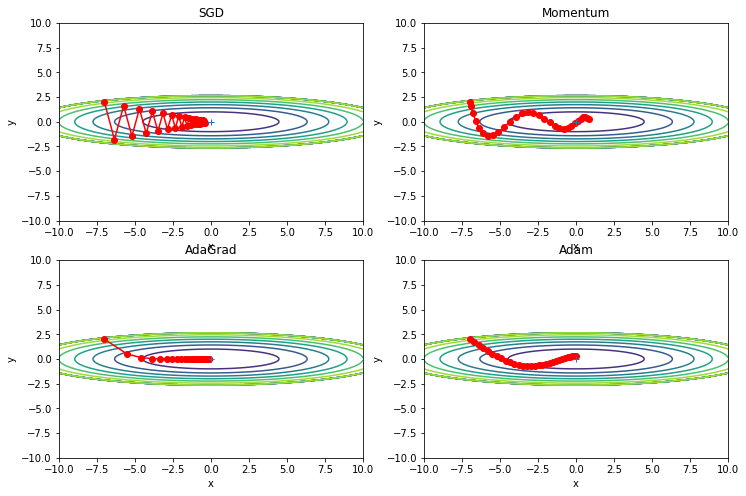

In [7]:
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = {}
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

plt.figure(figsize=(12,8))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

===========iteration:0===========
SGD:2.412890056767121
Momentum:2.3148426732196885
AdaGrad:2.1405654583627127
Adam:2.1917800294591965
===========iteration:100===========
SGD:1.6248519426506438
Momentum:0.3569315419637008
AdaGrad:0.1645180826805766
Adam:0.29445050308657617
===========iteration:200===========
SGD:0.84919827068468
Momentum:0.23434575745887554
AdaGrad:0.11000694447253603
Adam:0.18227679642520078
===========iteration:300===========
SGD:0.5889265205733435
Momentum:0.2316597961999589
AdaGrad:0.09002297877000738
Adam:0.10184811376911282
===========iteration:400===========
SGD:0.5234592931081736
Momentum:0.2201392860908703
AdaGrad:0.1588475407310148
Adam:0.19354994668520525
===========iteration:500===========
SGD:0.49490213417712614
Momentum:0.18137264441420048
AdaGrad:0.050288923464502686
Adam:0.09191332794086296
===========iteration:600===========
SGD:0.4391995365578118
Momentum:0.30592508511642835
AdaGrad:0.13294028772830652
Adam:0.21854244047942845
===========iteration:700

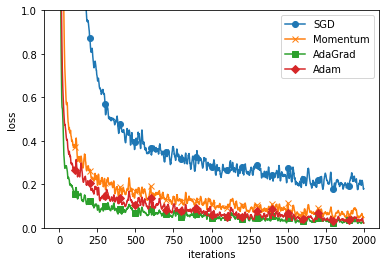

In [8]:
# MNIST 데이터셋으로 각 optimizer 성능 비교
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    

# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

### 6.2 가중치의 초깃값

- 가중치 감소 : 가중치 매개변수의 값이 작아지도록 학습하는 방법 --> 오버피팅 억제!

가중치의 초깃값을 0으로 (균일한 값으로) 설정하면 안좋은 이유:

오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문

--> 초깃값을 무작위로 설정해야 함

In [9]:
# 가중치 초깃값에 따른 은닉층의 활성화값 분포 관찰

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100          # 각 은닉층의 노드 수
hidden_layer_size = 5   # 은닉층이 5개
activations = {}        # 이곳에 활성화값 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 1   # 가중치의 표준편차가 1인 정규분포
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

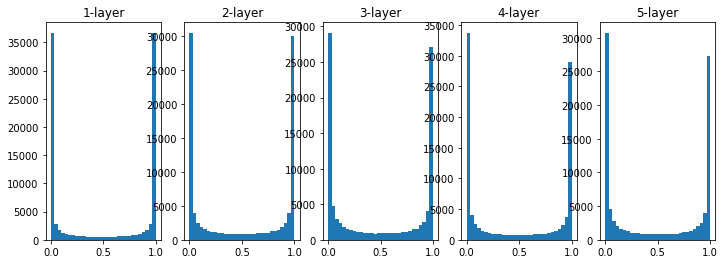

In [10]:
plt.figure(figsize=(12,4))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

각 층의 활성화값들이 0과 1에 치우쳐 있다.

--> 미분이 0에 다가가기 때문에 역전파의 기울기 값이 입력층에 다가갈수록 점점 작아지다가 사라진다. ( **기울기 소실** )

In [11]:
# 가중치 표준편차 바꿔서 실험

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100         
hidden_layer_size = 5  
activations = {}       

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 0.01   # 가중치의 표준편차가 0.01인 정규분포
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

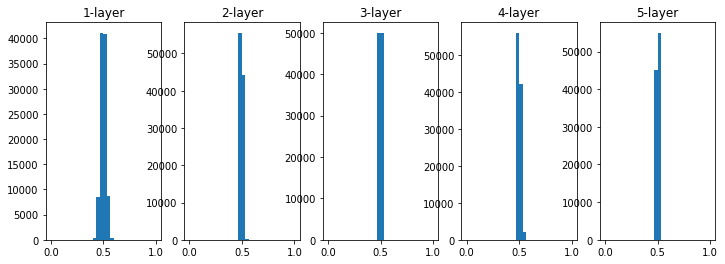

In [12]:
plt.figure(figsize=(12,4))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

0.5 부근에 집중됨 --> 기울기 소실은 해결했으나 / 활성화값이 치우쳐져서 여러 뉴런을 둔 의미가 없어지게 된다.

- 각 층의 활성화값은 고르게 분포되어야 한다. ( 신경망 학습을 효율적으로 이뤄지게 하기 위해 )

---

- Xavier 초깃값 :

 앞 계층의 노드가 n개라면, 표준편차가 $\frac{1}{\sqrt{n}}$ 인 분포 사용

In [13]:
# Xavier 초깃값 사용

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100          # 앞층의 노드 수
hidden_layer_size = 5 
activations = {} 

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)   # Xavier 초깃값 사용
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

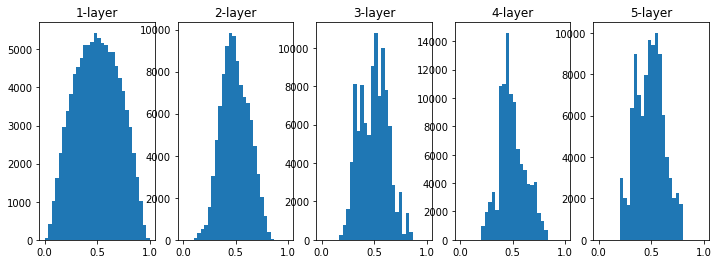

In [14]:
plt.figure(figsize=(12,4))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

층이 깊어지면서 형태가 다소 일그러지지만, 앞에서 본 방식보다는 확실히 넓게 분포됨! --> 학습 효율적일 것으로 기대됨

In [15]:
# 활성화 함수로 tanh 사용

def tanh(x):
    return np.tanh(x)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5 
activations = {} 

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)   # Xavier 초깃값 사용
    a = np.dot(x, w)
    z = tanh(a)
    activations[i] = z

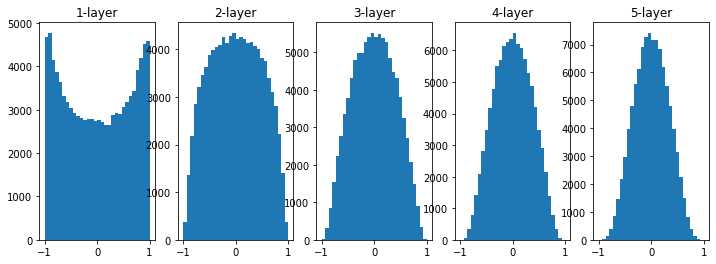

In [16]:
plt.figure(figsize=(12,4))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(-1,1))
plt.show()

- 활성화함수로 tanh 함수를 쓰니까 말끔한 종 모양으로 분포됨!

sigmoid는 (0, 0.5)에서 대칭이고, tanh는 (0, 0)에서 대칭이다.

활성화 함수용으로는 원점에서 대칭인 함수가 바람직하다고 알려져 있다.

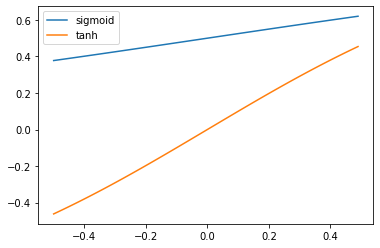

In [17]:
x = np.arange(-0.5, 0.5, 0.01)
y1 = sigmoid(x)
y2 = tanh(x)
plt.plot(x,y1)
plt.plot(x,y2)
plt.legend(['sigmoid','tanh'])
plt.show()

--> sigmoid와 tanh함수는 좌우대칭이라 중앙부근에서 선형이기 때문에 Xavier 초깃값이 적당하다

반면 ReLU를 사용할 때는 **' He 초깃값 '**을 이용한다

- He 초깃값 :

 앞 계층의 노드가 n개일 때, 표준편차가 $\sqrt{\frac{2}{n}}$ 인 분포 사용

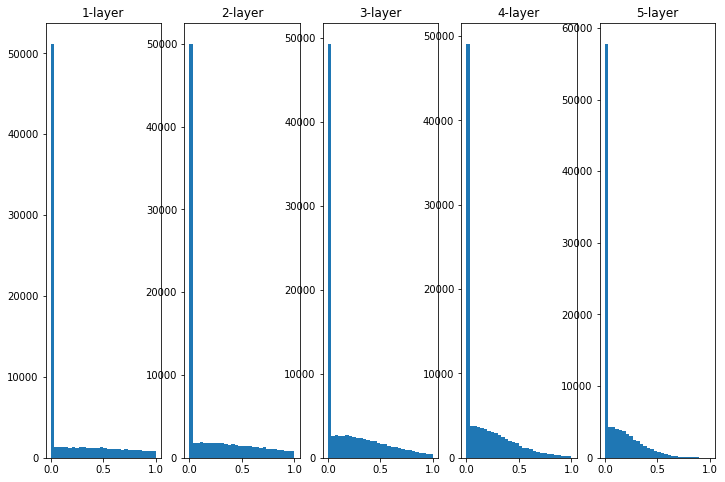

In [18]:
# 활성화 함수로 ReLU 사용 (Xavier 초깃값)

def ReLU(x):
    return np.maximum(x, 0)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5 
activations = {} 

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)   # Xavier 초깃값 사용
    a = np.dot(x, w)
    z = ReLU(a)
    activations[i] = z

# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

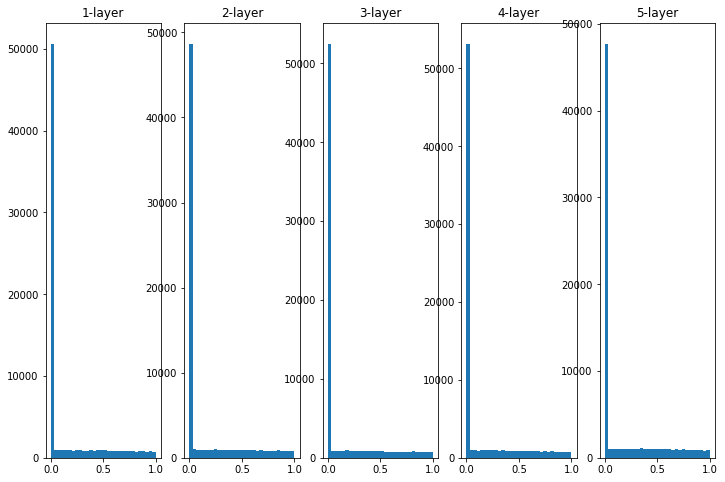

In [19]:
# 활성화 함수로 ReLU 사용 (He 초깃값)

def ReLU(x):
    return np.maximum(x, 0)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5 
activations = {} 

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * np.sqrt(2/node_num)   # He 초깃값 사용
    a = np.dot(x, w)
    z = ReLU(a)
    activations[i] = z

# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

ReLU를 사용한 경우

Xavier : 층이 깊어지면서 치우침이 조금씩 커짐

He : 층이 깊어져도 분포가 균일하게 유지됨

===========iteration:0===========
std=0.01:2.30256113749461
Xavier:2.3055460858225088
He:2.3560856721919894
===========iteration:100===========
std=0.01:2.302765415346977
Xavier:2.276499666470492
He:1.6055885765941862
===========iteration:200===========
std=0.01:2.3023846096089704
Xavier:2.235136790688754
He:0.9489054579172322
===========iteration:300===========
std=0.01:2.30030579659978
Xavier:2.089160698098615
He:0.5392978597649501
===========iteration:400===========
std=0.01:2.3016879142200266
Xavier:1.7979294860944057
He:0.3437210841922913
===========iteration:500===========
std=0.01:2.304038389405724
Xavier:1.4356204226150406
He:0.41959579730399865
===========iteration:600===========
std=0.01:2.29975300456727
Xavier:1.1265212679958005
He:0.3804535871662745
===========iteration:700===========
std=0.01:2.3021914835787998
Xavier:0.7913632867321281
He:0.2231146268386366
===========iteration:800===========
std=0.01:2.3015969372719294
Xavier:0.6875581405570891
He:0.3304969860912091
====

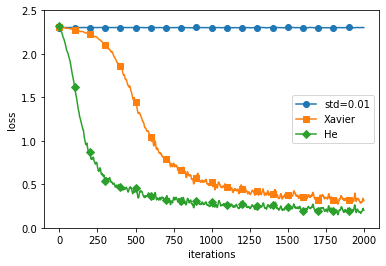

In [20]:
# MNIST 데이터셋으로 가중치 초깃값 비교하기 (활성화함수로 ReLU함수 적용)

from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

### 6.3 배치 정규화

활성화값이 적당히 분포되도록 조정하는 것

- 학습을 빨리 진행할 수 있다.

- 초깃값에 크게 의존하지 않는다.

- 오버피팅을 억제한다.

============== 1/16 ==============
epoch:0 | 0.099 - 0.101
epoch:1 | 0.105 - 0.12
epoch:2 | 0.105 - 0.156
epoch:3 | 0.105 - 0.187
epoch:4 | 0.105 - 0.21
epoch:5 | 0.105 - 0.224
epoch:6 | 0.105 - 0.24
epoch:7 | 0.105 - 0.254
epoch:8 | 0.116 - 0.28
epoch:9 | 0.116 - 0.3
epoch:10 | 0.116 - 0.324
epoch:11 | 0.116 - 0.341
epoch:12 | 0.116 - 0.355
epoch:13 | 0.116 - 0.361
epoch:14 | 0.116 - 0.376
epoch:15 | 0.116 - 0.393
epoch:16 | 0.116 - 0.403
epoch:17 | 0.116 - 0.412
epoch:18 | 0.116 - 0.422


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.437
============== 2/16 ==============
epoch:0 | 0.094 - 0.091


/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.078
epoch:2 | 0.097 - 0.085
epoch:3 | 0.097 - 0.126
epoch:4 | 0.097 - 0.145
epoch:5 | 0.097 - 0.164
epoch:6 | 0.097 - 0.19
epoch:7 | 0.097 - 0.222
epoch:8 | 0.097 - 0.247
epoch:9 | 0.097 - 0.271
epoch:10 | 0.097 - 0.31
epoch:11 | 0.097 - 0.344
epoch:12 | 0.097 - 0.361
epoch:13 | 0.097 - 0.38
epoch:14 | 0.097 - 0.408
epoch:15 | 0.097 - 0.416
epoch:16 | 0.097 - 0.438
epoch:17 | 0.097 - 0.457
epoch:18 | 0.097 - 0.472


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.491
============== 3/16 ==============
epoch:0 | 0.097 - 0.131
epoch:1 | 0.31 - 0.158
epoch:2 | 0.458 - 0.183
epoch:3 | 0.564 - 0.194
epoch:4 | 0.643 - 0.22
epoch:5 | 0.692 - 0.255
epoch:6 | 0.746 - 0.307
epoch:7 | 0.787 - 0.339
epoch:8 | 0.829 - 0.375
epoch:9 | 0.837 - 0.404
epoch:10 | 0.854 - 0.439
epoch:11 | 0.877 - 0.476
epoch:12 | 0.901 - 0.499
epoch:13 | 0.923 - 0.524
epoch:14 | 0.92 - 0.552
epoch:15 | 0.933 - 0.575
epoch:16 | 0.943 - 0.593
epoch:17 | 0.943 - 0.614
epoch:18 | 0.952 - 0.641


No handles with labels found to put in legend.


epoch:19 | 0.957 - 0.649
============== 4/16 ==============
epoch:0 | 0.088 - 0.119
epoch:1 | 0.261 - 0.121
epoch:2 | 0.394 - 0.137
epoch:3 | 0.494 - 0.194
epoch:4 | 0.56 - 0.255
epoch:5 | 0.631 - 0.33
epoch:6 | 0.673 - 0.392
epoch:7 | 0.715 - 0.451
epoch:8 | 0.745 - 0.496
epoch:9 | 0.766 - 0.536
epoch:10 | 0.782 - 0.591
epoch:11 | 0.803 - 0.613
epoch:12 | 0.826 - 0.645
epoch:13 | 0.832 - 0.667
epoch:14 | 0.832 - 0.699
epoch:15 | 0.842 - 0.726
epoch:16 | 0.846 - 0.741
epoch:17 | 0.865 - 0.756
epoch:18 | 0.873 - 0.768


No handles with labels found to put in legend.


epoch:19 | 0.881 - 0.781
============== 5/16 ==============
epoch:0 | 0.099 - 0.089
epoch:1 | 0.11 - 0.15
epoch:2 | 0.115 - 0.326
epoch:3 | 0.117 - 0.436
epoch:4 | 0.13 - 0.501
epoch:5 | 0.136 - 0.58
epoch:6 | 0.15 - 0.627
epoch:7 | 0.159 - 0.672
epoch:8 | 0.178 - 0.703
epoch:9 | 0.19 - 0.734
epoch:10 | 0.196 - 0.764
epoch:11 | 0.209 - 0.797
epoch:12 | 0.232 - 0.818
epoch:13 | 0.248 - 0.841
epoch:14 | 0.273 - 0.85
epoch:15 | 0.282 - 0.864
epoch:16 | 0.309 - 0.878
epoch:17 | 0.322 - 0.882
epoch:18 | 0.322 - 0.895


No handles with labels found to put in legend.


epoch:19 | 0.324 - 0.903
============== 6/16 ==============
epoch:0 | 0.112 - 0.119
epoch:1 | 0.123 - 0.247
epoch:2 | 0.117 - 0.439
epoch:3 | 0.117 - 0.561
epoch:4 | 0.117 - 0.637
epoch:5 | 0.121 - 0.668
epoch:6 | 0.117 - 0.711
epoch:7 | 0.117 - 0.751
epoch:8 | 0.117 - 0.783
epoch:9 | 0.119 - 0.818
epoch:10 | 0.131 - 0.827
epoch:11 | 0.117 - 0.846
epoch:12 | 0.117 - 0.859
epoch:13 | 0.117 - 0.869
epoch:14 | 0.117 - 0.883
epoch:15 | 0.117 - 0.898
epoch:16 | 0.117 - 0.901
epoch:17 | 0.117 - 0.914
epoch:18 | 0.117 - 0.926


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.931
============== 7/16 ==============
epoch:0 | 0.13 - 0.097
epoch:1 | 0.1 - 0.223
epoch:2 | 0.117 - 0.581
epoch:3 | 0.117 - 0.703
epoch:4 | 0.117 - 0.771
epoch:5 | 0.117 - 0.805
epoch:6 | 0.117 - 0.833
epoch:7 | 0.117 - 0.859
epoch:8 | 0.117 - 0.887
epoch:9 | 0.117 - 0.91
epoch:10 | 0.117 - 0.931
epoch:11 | 0.117 - 0.941
epoch:12 | 0.117 - 0.954
epoch:13 | 0.117 - 0.963
epoch:14 | 0.117 - 0.97
epoch:15 | 0.117 - 0.982
epoch:16 | 0.117 - 0.985
epoch:17 | 0.117 - 0.989
epoch:18 | 0.117 - 0.992


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.994
============== 8/16 ==============
epoch:0 | 0.097 - 0.066
epoch:1 | 0.117 - 0.542
epoch:2 | 0.117 - 0.73
epoch:3 | 0.117 - 0.801
epoch:4 | 0.117 - 0.836
epoch:5 | 0.117 - 0.858
epoch:6 | 0.117 - 0.886
epoch:7 | 0.117 - 0.922
epoch:8 | 0.117 - 0.937
epoch:9 | 0.117 - 0.964
epoch:10 | 0.117 - 0.975
epoch:11 | 0.117 - 0.983
epoch:12 | 0.116 - 0.988
epoch:13 | 0.116 - 0.994
epoch:14 | 0.116 - 0.996
epoch:15 | 0.116 - 0.996
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.999
epoch:18 | 0.116 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.116 - 1.0
============== 9/16 ==============
epoch:0 | 0.097 - 0.095
epoch:1 | 0.117 - 0.397
epoch:2 | 0.116 - 0.639
epoch:3 | 0.116 - 0.781
epoch:4 | 0.116 - 0.826
epoch:5 | 0.116 - 0.914
epoch:6 | 0.117 - 0.958
epoch:7 | 0.117 - 0.963
epoch:8 | 0.117 - 0.979
epoch:9 | 0.117 - 0.986
epoch:10 | 0.117 - 0.989
epoch:11 | 0.117 - 0.993
epoch:12 | 0.117 - 0.996
epoch:13 | 0.117 - 0.996
epoch:14 | 0.117 - 0.996
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.998
epoch:17 | 0.117 - 0.998
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.999
============== 10/16 ==============
epoch:0 | 0.116 - 0.098
epoch:1 | 0.117 - 0.48
epoch:2 | 0.117 - 0.653
epoch:3 | 0.117 - 0.715
epoch:4 | 0.117 - 0.755
epoch:5 | 0.116 - 0.767
epoch:6 | 0.116 - 0.816
epoch:7 | 0.116 - 0.814
epoch:8 | 0.116 - 0.881
epoch:9 | 0.116 - 0.895
epoch:10 | 0.116 - 0.902
epoch:11 | 0.116 - 0.979
epoch:12 | 0.116 - 0.989
epoch:13 | 0.117 - 0.994
epoch:14 | 0.116 - 0.987
epoch:15 | 0.116 - 0.944
epoch:16 | 0.117 - 0.984
epoch:17 | 0.116 - 0.997
epoch:18 | 0.116 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.999
============== 11/16 ==============
epoch:0 | 0.097 - 0.107
epoch:1 | 0.097 - 0.45
epoch:2 | 0.116 - 0.617
epoch:3 | 0.116 - 0.743
epoch:4 | 0.116 - 0.687
epoch:5 | 0.117 - 0.749
epoch:6 | 0.117 - 0.78
epoch:7 | 0.117 - 0.779
epoch:8 | 0.117 - 0.793
epoch:9 | 0.116 - 0.801
epoch:10 | 0.116 - 0.884
epoch:11 | 0.117 - 0.892
epoch:12 | 0.117 - 0.895
epoch:13 | 0.116 - 0.902
epoch:14 | 0.117 - 0.877
epoch:15 | 0.116 - 0.901
epoch:16 | 0.117 - 0.906
epoch:17 | 0.117 - 0.902
epoch:18 | 0.116 - 0.875


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.896
============== 12/16 ==============
epoch:0 | 0.117 - 0.169
epoch:1 | 0.116 - 0.539
epoch:2 | 0.116 - 0.633
epoch:3 | 0.116 - 0.667
epoch:4 | 0.116 - 0.703
epoch:5 | 0.116 - 0.785
epoch:6 | 0.116 - 0.751
epoch:7 | 0.116 - 0.809
epoch:8 | 0.116 - 0.755
epoch:9 | 0.116 - 0.836
epoch:10 | 0.116 - 0.849
epoch:11 | 0.116 - 0.835
epoch:12 | 0.116 - 0.84
epoch:13 | 0.117 - 0.846
epoch:14 | 0.117 - 0.821
epoch:15 | 0.117 - 0.813
epoch:16 | 0.116 - 0.808
epoch:17 | 0.116 - 0.807
epoch:18 | 0.116 - 0.814


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.905
============== 13/16 ==============
epoch:0 | 0.097 - 0.097
epoch:1 | 0.117 - 0.244
epoch:2 | 0.116 - 0.486
epoch:3 | 0.116 - 0.457
epoch:4 | 0.116 - 0.52
epoch:5 | 0.116 - 0.509
epoch:6 | 0.116 - 0.507
epoch:7 | 0.116 - 0.502
epoch:8 | 0.116 - 0.507
epoch:9 | 0.116 - 0.497
epoch:10 | 0.116 - 0.509
epoch:11 | 0.117 - 0.507
epoch:12 | 0.116 - 0.523
epoch:13 | 0.116 - 0.526
epoch:14 | 0.117 - 0.536
epoch:15 | 0.116 - 0.533
epoch:16 | 0.116 - 0.606
epoch:17 | 0.116 - 0.598
epoch:18 | 0.116 - 0.593


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.631
============== 14/16 ==============
epoch:0 | 0.117 - 0.097
epoch:1 | 0.116 - 0.28
epoch:2 | 0.117 - 0.387
epoch:3 | 0.117 - 0.421
epoch:4 | 0.117 - 0.418
epoch:5 | 0.117 - 0.419
epoch:6 | 0.117 - 0.426
epoch:7 | 0.117 - 0.426
epoch:8 | 0.117 - 0.425
epoch:9 | 0.117 - 0.431
epoch:10 | 0.117 - 0.429
epoch:11 | 0.117 - 0.43
epoch:12 | 0.117 - 0.438
epoch:13 | 0.117 - 0.438
epoch:14 | 0.117 - 0.446
epoch:15 | 0.117 - 0.438
epoch:16 | 0.117 - 0.428
epoch:17 | 0.117 - 0.433
epoch:18 | 0.117 - 0.432


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.423
============== 15/16 ==============
epoch:0 | 0.093 - 0.18
epoch:1 | 0.117 - 0.377
epoch:2 | 0.117 - 0.401
epoch:3 | 0.116 - 0.465
epoch:4 | 0.116 - 0.493
epoch:5 | 0.116 - 0.491
epoch:6 | 0.116 - 0.512
epoch:7 | 0.116 - 0.52
epoch:8 | 0.116 - 0.491
epoch:9 | 0.116 - 0.51
epoch:10 | 0.116 - 0.518
epoch:11 | 0.116 - 0.517
epoch:12 | 0.116 - 0.505
epoch:13 | 0.116 - 0.519
epoch:14 | 0.116 - 0.52
epoch:15 | 0.116 - 0.518
epoch:16 | 0.117 - 0.52
epoch:17 | 0.117 - 0.52
epoch:18 | 0.117 - 0.513


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.521
============== 16/16 ==============
epoch:0 | 0.1 - 0.099
epoch:1 | 0.105 - 0.309
epoch:2 | 0.105 - 0.351
epoch:3 | 0.105 - 0.363
epoch:4 | 0.105 - 0.393
epoch:5 | 0.116 - 0.403
epoch:6 | 0.117 - 0.406
epoch:7 | 0.117 - 0.418
epoch:8 | 0.117 - 0.405
epoch:9 | 0.117 - 0.413
epoch:10 | 0.117 - 0.424
epoch:11 | 0.117 - 0.401
epoch:12 | 0.117 - 0.42
epoch:13 | 0.117 - 0.425
epoch:14 | 0.117 - 0.421
epoch:15 | 0.117 - 0.432
epoch:16 | 0.117 - 0.428
epoch:17 | 0.117 - 0.428
epoch:18 | 0.117 - 0.43
epoch:19 | 0.117 - 0.432


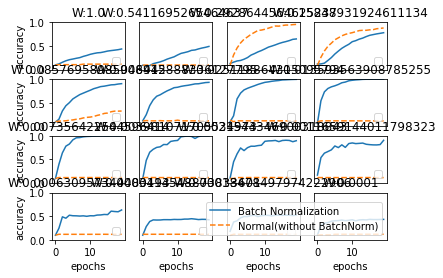

In [21]:
from ch06 import batch_norm_test

### 6.4 바른 학습을 위해

**오버피팅**은 주로 다음의 두 경우에 일어난다.

- 매개변수가 많고 표현력이 높은 모델

- 훈련 데이터가 작음

이 두 요건을 일부러 충족하여 오버피팅을 일으켜보자

In [22]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

In [23]:
network = MultiLayerNet(input_size=784, hidden_size_list=[100,100,100,100,100,100], output_size=10)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

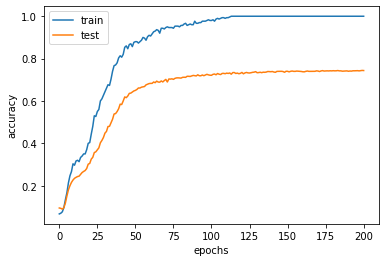

In [25]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

- **가중치 감소** : 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅 억제

 (오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문)

 예를 들어, 가중치의 제곱 노름을 손실함수에 더한다.

 $L(W) + \frac{1}{2}\lambda W^2$

 - L2 노름을 더해주면, 해당 손실값이 높아지고, 학습은 손실값을 줄이는 방향으로 진행되므로, 가중치가 클수록 가중치에 대한 패널티를 줄수 있는 것이다.

 - $\lambda$가 크다면 모델이 훈련 데이터에 대해서 적합한 매개 변수를 찾는 것보다 규제를 위해 추가된 항들을 작게 유지하는 것을 우선한다는 의미가 됨.

 ---

- **드롭아웃** : 뉴런을 임의로 삭제하면서 학습하는 방법

 시험 때는 모든 뉴런에 신호를 전달 ( 단, 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력 )

In [27]:
# 드롭아웃 구현

class Dropout(object):
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:   # 훈련 시에 self.mask에 삭제할 뉴런을 False로 표시
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            # 배열을 무작위로 생성, 그 값이 dropout_ratio보다 큰 것만 True로 설정
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)  # 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력
        
    def backward(self, dout):
        return dout * self.mask   # 순전파에서 False가 된 것들은 역전파에도 신호 차단

train loss:2.318854330889956
=== epoch:1, train acc:0.14333333333333334, test acc:0.1314 ===
train loss:2.304668606103671
train loss:2.283557934515842
train loss:2.3096423920877642
=== epoch:2, train acc:0.14333333333333334, test acc:0.1325 ===
train loss:2.323817915426522
train loss:2.312567731950145
train loss:2.275227665076752
=== epoch:3, train acc:0.13, test acc:0.1352 ===
train loss:2.27353872253281
train loss:2.301486334471781
train loss:2.2774928575476183
=== epoch:4, train acc:0.12666666666666668, test acc:0.1372 ===
train loss:2.299762885656706
train loss:2.28795003725428
train loss:2.309030261842398
=== epoch:5, train acc:0.14, test acc:0.1412 ===
train loss:2.292069269492766
train loss:2.266771151122549
train loss:2.2794290955937644
=== epoch:6, train acc:0.14333333333333334, test acc:0.1455 ===
train loss:2.2892238554331983
train loss:2.2811983678763466
train loss:2.2925978662722013
=== epoch:7, train acc:0.13666666666666666, test acc:0.1481 ===
train loss:2.28006055705233

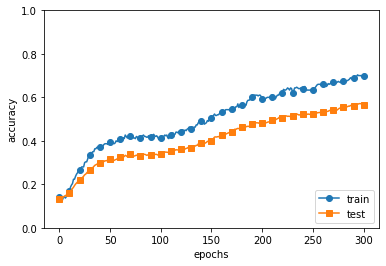

In [49]:
# MNIST 데이터셋으로 드롭아웃 효과 확인하기

from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer  # 신경망 학습을 대신 해주는 메서드

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

훈련 데이터와 시험 데이터에 대한 정확도 차이가 줄었다 --> 오버피팅 억제!

머신러닝에서의 앙상블 학습과 유사하다 ( 드롭아웃이 학습 때 매번 다른 모델을 학습시키는 것으로 볼 수 있다 )

### 6.5 적절한 하이퍼파라미터 값 찾기

- 훈련 데이터 : 매개변수 학습

- 검증 데이터 : 하이퍼파라미터 성능 평가

- 시험 데이터 : 신경망의 범용 성능 평가

In [54]:
# 훈련 데이터에서 검증 데이터 분리하기

from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

x_train, t_train = shuffle_dataset(x_train, t_train)  # 훈련 데이터 섞기

validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

하이퍼파라미터 최적화 : 

1. 하이퍼파라미터 값의 범위 설정 (주로, 로그 스케일로 지정)

2. 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출

3. 2단계에서 샘플링한 하이퍼파라미터의 값을 사용하여 학습 후, 검증 데이터로 정확도 평가 (에폭은 작게 설정)

4. 2단계와 3단계를 특정 획수 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.

범위가 어느 정도 좁아지면 그 범위에서 값을 하나 골라낸다.

In [81]:
# 무작위로 하이퍼파라미터 범위 설정
weight_decay = 10 ** np.random.uniform(-8,-4)  # random.uniform(a,b): a,b 사이의 부동소수점 난수 발생
lr = 10 ** np.random.uniform(-6,-2)

In [83]:
print(weight_decay, lr)

1.2588858736524715e-05 0.0002943243707482464


다양한 하이퍼파라미터 값으로 학습을 반복하며 관찰해보자

val acc:0.48 | lr:0.00346334550388214, weight decay:1.364321743823352e-05
val acc:0.09 | lr:2.57953196256745e-05, weight decay:2.6599622491814813e-08
val acc:0.1 | lr:9.174551743209555e-05, weight decay:3.400622686970287e-06
val acc:0.07 | lr:1.634977866172414e-06, weight decay:2.8491315275684142e-05
val acc:0.16 | lr:0.00082397706766713, weight decay:2.0120636162775281e-07
val acc:0.07 | lr:1.706676184786581e-06, weight decay:1.5078915654613815e-07
val acc:0.11 | lr:6.0483433836846036e-05, weight decay:4.451919844003293e-05
val acc:0.14 | lr:0.00012573470877897988, weight decay:1.2459401056222052e-07
val acc:0.11 | lr:0.00027979674643229284, weight decay:8.437683096670309e-06
val acc:0.14 | lr:1.884117761417051e-06, weight decay:1.1639996710197597e-07
val acc:0.04 | lr:2.849231378208544e-06, weight decay:2.117941144851014e-05
val acc:0.1 | lr:0.00027322484650198035, weight decay:2.2523643473897366e-05
val acc:0.11 | lr:0.0003151878324499096, weight decay:1.5600441519923142e-08
val acc

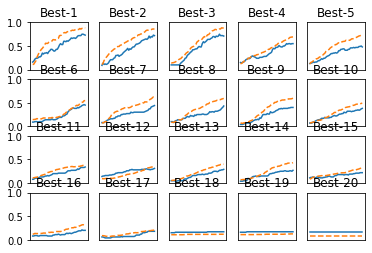

In [84]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

    Best-1(val acc:0.73) | lr:0.008507374603905195, weight decay:3.5803316361309514e-05

    Best-2(val acc:0.72) | lr:0.007215643739575296, weight decay:1.2035895837918405e-07

    Best-3(val acc:0.71) | lr:0.009188064115272945, weight decay:4.007853060571838e-05

    Best-4(val acc:0.55) | lr:0.005222172711613795, weight decay:9.153348131843417e-05

    Best-5(val acc:0.48) | lr:0.00346334550388214, weight decay:1.364321743823352e-05

가장 잘 학습이 된 모델의 하이퍼파라미터 값의 범위를 관찰하고 범위를 좁혀나간다 --> 작업 반복 --> 하이퍼파라미터 값 선택